In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from torch.utils.data import Dataset, DataLoader, Subset
# from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image
import os
import pandas as pd
import random
import torch.nn as nn
import timm
import yacs.config
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

from torchvision import models

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
from collections import OrderedDict
import torch
import timm


import torch.nn.functional as F 
import torch
import torch.nn as nn
from torchvision import models
import timm
from functools import partial

import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# Imports specifiek voor de Swin code
from timm.layers import DropPath, to_2tuple, trunc_normal_ 
from torch.utils.data import WeightedRandomSampler

In [3]:
# 1. Stel de random seed in voor Python's random module
random.seed(42)

# 2. Stel de random seed in voor NumPy
np.random.seed(42)

# 3. Stel de random seed in voor PyTorch
torch.manual_seed(42)

# Voor CUDA (indien je een GPU gebruikt) 
torch.cuda.manual_seed(42)

In [4]:
import torch

# Laad het checkpoint
checkpoint = torch.load('./weights_chexnet/model.pth')

# Haal de state_dict eruit
state_dict = checkpoint['state_dict']

# Print de eerste paar keys van de state_dict om de structuur te bekijken
for i, key in enumerate(state_dict.keys()):
    print(key)
    if i > 5:  # Print de eerste 6 keys
        break

module.densenet121.features.conv0.weight
module.densenet121.features.norm0.weight
module.densenet121.features.norm0.bias
module.densenet121.features.norm0.running_mean
module.densenet121.features.norm0.running_var
module.densenet121.features.denseblock1.denselayer1.norm.1.weight
module.densenet121.features.denseblock1.denselayer1.norm.1.bias


In [5]:
# Dataset class
class CheXpertDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.df.iloc[idx, 1:].values.astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, labels

# Load CSVs
df_train = pd.read_csv('./data/train_labels.csv')  # bevat kolommen 'image_path' en 'labels'
df_val = pd.read_csv('./data/val_labels.csv')
df_test = pd.read_csv('./data/test_labels.csv')
# Convert to string and split multi-label strings
df_train['Finding Labels'] = df_train['Finding Labels'].astype(str).str.split('|')
df_val['Finding Labels'] = df_val['Finding Labels'].astype(str).str.split('|')
df_test['Finding Labels'] = df_test['Finding Labels'].astype(str).str.split('|')

# One-hot encode labels
mlb = MultiLabelBinarizer()
label_matrix_train = mlb.fit_transform(df_train['Finding Labels'])
label_matrix_val = mlb.transform(df_val['Finding Labels'])
label_matrix_test = mlb.transform(df_test['Finding Labels'])

# Add the one-hot encoded labels to the Dataframe
label_df_train = pd.DataFrame(label_matrix_train, columns=mlb.classes_)
df_train = pd.concat([df_train[['Image Index']], label_df_train], axis=1)

label_df_val = pd.DataFrame(label_matrix_val, columns=mlb.classes_)
df_val = pd.concat([df_val[['Image Index']], label_df_val], axis=1)

label_df_test = pd.DataFrame(label_matrix_test, columns=mlb.classes_)
df_test = pd.concat([df_test[['Image Index']], label_df_test], axis=1)


# **Filter out 'No Finding' samples**
df_train = df_train[df_train['No Finding'] == 0]
df_val = df_val[df_val['No Finding'] == 0]
df_test = df_test[df_test['No Finding'] == 0]

# Drop the 'No Finding' column
df_train = df_train.drop(columns=['No Finding'])
df_val = df_val.drop(columns=['No Finding'])
df_test = df_test.drop(columns=['No Finding'])

df_train.to_csv('./data/train_labels_encoded.csv', index=False)
df_val.to_csv('./data/val_labels_encoded.csv', index=False)
df_test.to_csv('./data/test_labels_encoded.csv', index=False)

# Transformaties voor de trainingsset (inclusief augmentatie)
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomRotation(degrees=15),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    # Use 3-channel normalization matching ImageNet if you are using ImageNet pretraining
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaties voor de validatie- en testsets (alleen resizing en tensor conversie)
val_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    # Use 3-channel normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creëer de Datasets
train_dataset = CheXpertDataset(csv_file='./data/train_labels_encoded.csv', root_dir='./data/train', transform=train_transforms)
val_dataset = CheXpertDataset(csv_file='./data/val_labels_encoded.csv', root_dir='./data/val', transform=val_transforms)
test_dataset = CheXpertDataset(csv_file='./data/test_labels_encoded.csv', root_dir='./data/test', transform=val_transforms)

# Lees de labels opnieuw (zonder de eerste kolom met bestandsnaam)
label_array = df_train.iloc[:, 1:].values  # shape (num_samples, num_classes)

# Frequentie per klasse
label_freq = np.sum(label_array, axis=0)

# Gewicht voor elke klasse = omgekeerde frequentie
class_weights = 1.0 / (label_freq + 1e-6)  # Voeg kleine waarde toe om deling door 0 te vermijden

# Voor elke sample: som van gewichten voor de labels die het heeft
sample_weights = (label_array @ class_weights).astype(np.float32)

# # Normaliseren
# sample_weights /= np.sum(sample_weights)

# Sampler aanmaken
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Creëer de DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=os.cpu_count(), pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count(),pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= os.cpu_count(),pin_memory=True)

print('Samples train (*batchsize):',(len(train_loader)))
print('Samples val  (*batchsize):',(len(val_loader)))
print('Samples test  (*batchsize):',(len(test_loader)))
# subset
from torch.utils.data import Dataset, Subset, DataLoader
# Creëer de volledige dataset
full_train_dataset = CheXpertDataset(csv_file='./data/train_labels_encoded.csv', root_dir='./data/train', transform=train_transforms)
full_val_dataset = CheXpertDataset(csv_file='./data/val_labels_encoded.csv', root_dir='./data/val', transform=val_transforms)
# Definieer de grootte van de subset
subset_size_train = 100
subset_size_val = 10

# Genereer willekeurige indices
all_indices_train = list(range(len(full_train_dataset)))
random.shuffle(all_indices_train)
subset_indices_train = all_indices_train[:subset_size_train]

# Genereer willekeurige indices
all_indices_val= list(range(len(full_val_dataset)))
random.shuffle(all_indices_val)
subset_indices_val = all_indices_val[:subset_size_val]

# Creëer de subset met de willekeurige indices
train_subset = Subset(full_train_dataset, subset_indices_train)
val_subset = Subset(full_val_dataset, subset_indices_val)

# Gebruik de subset DataLoader
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader_subset = DataLoader(val_subset, batch_size=32, shuffle=True)

print('Samples subset train (*batchsize):',(len(train_loader_subset)))
print('Samples subset val  (*batchsize):',(len(val_loader_subset)))

Samples train (*batchsize): 1016
Samples val  (*batchsize): 111
Samples test  (*batchsize): 492
Samples subset train (*batchsize): 4
Samples subset val  (*batchsize): 1


/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


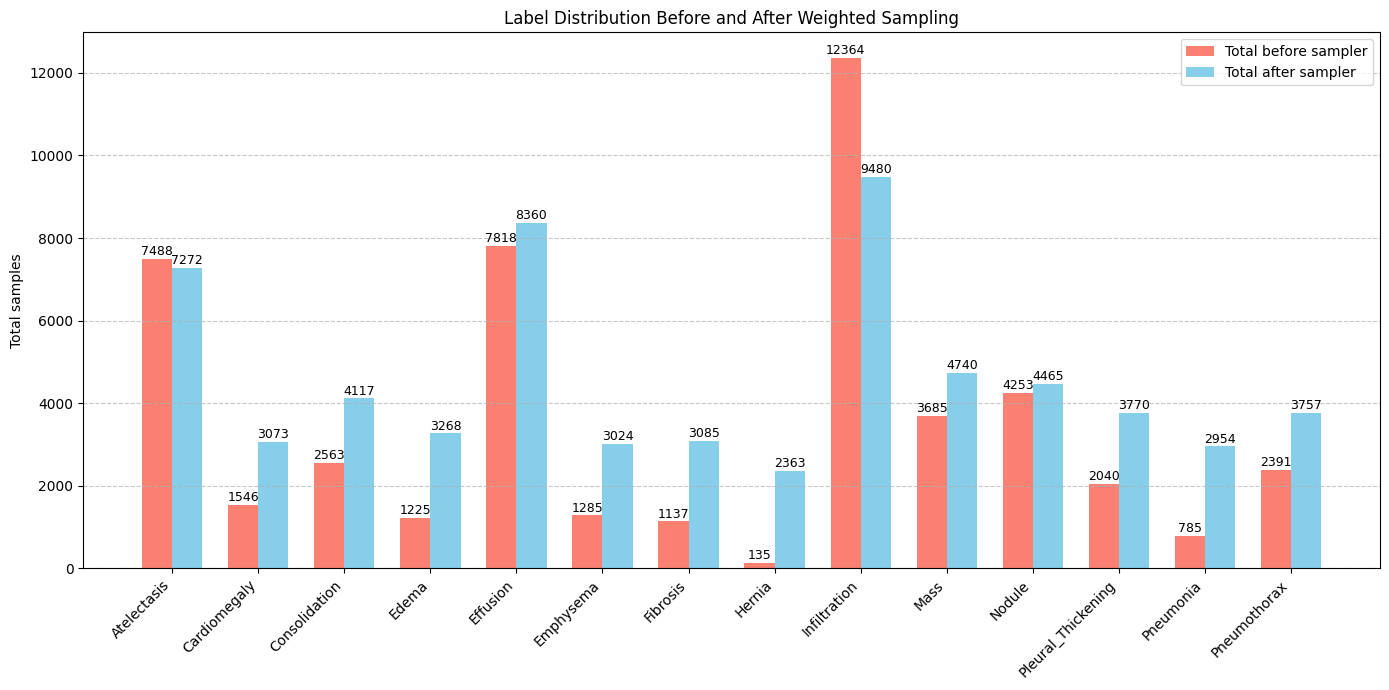

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Labels - pas aan naar jouw labelnamen
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
          'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
          'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# === Totalen vóór sampler (dataset totaal) ===
total_label_counts = label_array.sum(axis=0)

# === Totalen ná sampler (optellen over alle batches) ===
total_after_sampling = np.zeros(label_array.shape[1])
for _, labels_batch in train_loader:
    labels_np = labels_batch.numpy()
    total_after_sampling += labels_np.sum(axis=0)

# Plotten
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, total_label_counts, width, label='Total before sampler', color='salmon')
bars2 = ax.bar(x + width/2, total_after_sampling, width, label='Total after sampler', color='skyblue')

# Labels boven de bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 20, f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Total samples')
ax.set_title('Label Distribution Before and After Weighted Sampling')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [6]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, num_mlp_heads=3, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        self.num_mlp_heads = num_mlp_heads

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.heads = nn.ModuleList()
        if num_mlp_heads > 0:
            self.heads2 = nn.ModuleList()
        if num_mlp_heads > 1:
            self.heads3 = nn.ModuleList()
        if num_mlp_heads > 2:
            self.heads4 = nn.ModuleList()
        if num_mlp_heads > 0:
            self.relu = nn.ReLU()     # for 1 or more heads
        for i in range(num_classes):
            if num_mlp_heads == 0:
                self.heads.append(nn.Linear(self.num_features, 2))
            if num_mlp_heads == 1:
                self.heads.append(nn.Linear(self.num_features, 48))
                self.heads2.append(nn.Linear(48, 2))
            if num_mlp_heads == 2:
                self.heads.append(nn.Linear(self.num_features, 384))
                self.heads2.append(nn.Linear(384, 48))
                self.heads3.append(nn.Linear(48, 2))
            if num_mlp_heads == 3:
                self.heads.append(nn.Linear(self.num_features, 384))
                self.heads2.append(nn.Linear(384, 48))
                self.heads3.append(nn.Linear(48, 48))
                self.heads4.append(nn.Linear(48, 2))

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x) 

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        y = []
        for i in range(len(self.heads)):
            if self.num_mlp_heads == 0:
                y.append(self.heads[i](x))
            if self.num_mlp_heads == 1:
                y.append(self.heads2[i](self.relu(self.heads[i](x))))
            if self.num_mlp_heads == 2:
                y.append(self.heads3[i](self.relu(self.heads2[i](self.relu(self.heads[i](x))))))
            if self.num_mlp_heads == 3:
                y.append(self.heads4[i](self.relu(self.heads3[i](self.relu(self.heads2[i](self.relu(self.heads[i](x))))))))
        return y

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [7]:
def to_2tuple(x):
    return (x, x) if isinstance(x, int) else x

import torch
import torch.nn as nn
import torch.nn.functional as F # Nodig voor adaptive_avg_pool2d
import torchvision.models as models
import timm
import pandas as pd
import os
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer 
from collections import OrderedDict 
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm 
from sklearn.metrics import roc_auc_score 




class ParallelCheXNetSwin(nn.Module):
    def __init__(self, num_classes=14, img_size=224, chexnet_weights_path='./weights_chexnet/model.pth', swin_weights_path='./weights_swinchex/swin_base_patch4_window7_224_22k.pth'):
        super().__init__()
        self.img_size = img_size
        self.num_classes = num_classes

        self.cnn_backbone = models.densenet121(pretrained=False)

        # Vraag de oorspronkelijke input feature dimensie op voor het vervangen van de classifier vervangen
        # Dit is de dimensie van de features die uit het DenseNet backbone komen (na avg pooling)
        cnn_original_classifier_in_features = self.cnn_backbone.classifier.in_features

        # Vervang de originele classifier door een Identity laag
        self.cnn_backbone.classifier = nn.Identity()

        # Expliciet de Global Average Pooling toevoegen voor de CNN output in de forward pass
        self.cnn_avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Sla de opgehaalde feature dimensie op voor later gebruik met fusie sommatie
        self.cnn_feature_dim = cnn_original_classifier_in_features 
        print(f"CNN backbone feature dimension: {self.cnn_feature_dim}")

        if os.path.isfile(chexnet_weights_path):
            try:
                print(f"Try to load CheXNet weights from {chexnet_weights_path}...")
                chexnet_checkpoint = torch.load(chexnet_weights_path, map_location=torch.device('cpu'))
                original_chexnet_weights = chexnet_checkpoint['state_dict']


                # Filter en pas de state_dict aan voor de DenseNet backbone
                state_dict_to_load_cnn = OrderedDict()
                for k, v in original_chexnet_weights.items():
                    name = k
                    # Verwijder 'module.' prefix indien aanwezig (van DataParallel)
                    if name.startswith('module.'):
                        name = name[len('module.'):]
                    # Verwijder 'densenet121.' prefix indien aanwezig
                    if name.startswith('densenet121.'):
                        name = name[len('densenet121.'):]

                    # Corrigeer naamverschillen 
                    # Vervang '.norm.1' door '.norm1', '.norm.2' door '.norm2', etc.
                    name = name.replace('.norm.1', '.norm1')
                    name = name.replace('.norm.2', '.norm2')
                    name = name.replace('.conv.1', '.conv1')
                    name = name.replace('.conv.2', '.conv2')
                    name = name.replace('transition1.norm.1', 'transition1.norm1')
                    name = name.replace('transition1.conv.1', 'transition1.conv1')
                    name = name.replace('transition2.norm.1', 'transition2.norm1')
                    name = name.replace('transition2.conv.1', 'transition2.conv1')
                    name = name.replace('transition3.norm.1', 'transition3.norm1')
                    name = name.replace('transition3.conv.1', 'transition3.conv1')


                    # Behoud alleen de sleutels die hiermee beginnen NA prefixes verwijderd zijn
                    if name.startswith('features.'):
                        state_dict_to_load_cnn[name] = v
                    else:
                        print(f"Skipping key (after processing): {name}")
                        


                # Gefilterde en aangepaste gewichten in de cnn_backbone laden
                # Gebruik strict=False: de classifier niet laden en er kunnen nog andere kleine verschillen zijn.
                missing_keys, unexpected_keys = self.cnn_backbone.load_state_dict(state_dict_to_load_cnn, strict=False)

                print(f"CheXNet loaded from {chexnet_weights_path} in CNN backbone (strict=False).")
                if missing_keys:
                    # We verwachten dat de classifier sleutel(s) ontbreken.
                    # Als er andere ontbreken, is er nog een probleem.
                    print(f"Warning: Follwing keys are missing (expected by the classifier): {missing_keys}")
                if unexpected_keys:
                    print(f"Warning: Follwing unexpected keys found loading: {unexpected_keys}")

            except RuntimeError as e:
                 print(f"Error loading CheXNet weights: {e}")
            except Exception as e:
                 print(f"Error loading ChexNet weights: {e}")
        else:
             print(f"Warningg: CheXNet weights file not found on {chexnet_weights_path}.CNN Backbone start with random initialized weights.")

        print(f"CNN backbone feature dimension: {self.cnn_feature_dim}")

        # Swin Transformer Backbone 
        print(f"Initializing Swin Transformer model structure and load weights from file: {swin_weights_path}")

        # Configuratie parameters voor de SwinTransformer --> gebaseerd op swinchex
        self.swin_backbone = SwinTransformer(
             img_size=img_size, patch_size=4, in_chans=3, num_classes=0, # num_classes=0 verwijdert de originele Swin head
             embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32],
             window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
             drop_rate=0., attn_drop_rate=0., drop_path_rate=0.5,
             norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
             use_checkpoint=False, num_mlp_heads=3
        )

        # Inladen Swinchex weights
        if swin_weights_path and os.path.exists(swin_weights_path):
             try:
                 print(f"tro to load Swin weights from {swin_weights_path}...")
                 swin_checkpoint = torch.load(swin_weights_path, map_location=torch.device('cpu'), weights_only=False)

                 swin_state_dict = None
                 if isinstance(swin_checkpoint, dict):
                     if 'model' in swin_checkpoint:
                         swin_state_dict = swin_checkpoint['model']
                         print("State dict gevonden onder sleutel 'model'.")
                     elif 'state_dict' in swin_checkpoint:
                         swin_state_dict = swin_checkpoint['state_dict']
                         print("State dict gevonden onder sleutel 'state_dict'.")
                     else:
                         print("Checkpoint is een dict maar standaard sleutels ('model', 'state_dict') niet gevonden. Gaat ervan uit dat het checkpoint zelf de state dict is.")
                         swin_state_dict = swin_checkpoint
                 else:
                     print("Checkpoint is geen dict. Gaat ervan uit dat het checkpoint object zelf de state dict is.")
                     swin_state_dict = swin_checkpoint

                 if swin_state_dict is not None:
                     # Laad de gewichten in de SwinTransformer instantie.
                     # Strict=False is nodig om de originele classifier/head over te slaan.
                     missing_keys, unexpected_keys = self.swin_backbone.load_state_dict(swin_state_dict, strict=False)
                     print(f"Swin gewichten succesvol geladen vanuit {swin_weights_path} (strict=False).")
                     if missing_keys:
                         print(f"Warning: Follwing keys are missing (expected by the classifier): {missing_keys}")
                     if unexpected_keys:
                         print(f"Warning: Follwing unexpected keys found loading: {unexpected_keys}")
                 else:
                     print(f"ErrorL couldn't find state_dict in{swin_weights_path}.")

             except Exception as e:
                 print(f"Fout bij het laden van Swin gewichten: {e}")
        else:
             print(f"Warning: Swin weights bestand not found or path is None on {swin_weights_path}.")

        # De Swin feature dimensie komt van de originele SwinTransformer klasse
        self.swin_feature_dim = self.swin_backbone.num_features # Dit is 1024 voor Swin-Base
        print(f"Swin backbone feature dimension: {self.swin_feature_dim}")



        # Fusie methode: Concatenatie
        self.swin_project_for_fusion = nn.Identity() 
        fusion_output_dim = self.cnn_feature_dim + self.swin_feature_dim # Dimensie na concat - 2048

        print(f"CNN output dimension: {self.cnn_feature_dim}")
        print(f"Swin output dimension: {self.swin_feature_dim}")
        print(f"Fusion output dimension: {fusion_output_dim} (for concat)")


        # MLP Classifier
        # Input dimensie is de fusie output dimensie (1024 bij sommatie)
        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_feature_dim + self.swin_feature_dim, 1024),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
            # Sigmoid niet nodig door BCEWithLogitsLoss (zit ingebouwd)
        )

        print("CNN backbone parameters are trainbable (fine-tuning).")
        print("Swin Transformer backbone parameters are trainable (fine-tuning).")
        print("Fusion layer and Classifier parameters are trainable.")


    # --- Forward methode
    def forward(self, x):
        # Input x is de afbeelding (B, 3, H, W)

        # CNN Backbone forward
        cnn_feat = self.cnn_backbone.features(x)  
        cnn_feat = self.cnn_avgpool(cnn_feat)
        cnn_feat = torch.flatten(cnn_feat, 1)

        # Swin Transformer Backbone forward
        swin_feat = self.swin_backbone.forward_features(x)

        # Fusie (Concatenatie)
        swin_feat_projected = self.swin_project_for_fusion(swin_feat)
        fused_feat = torch.cat((cnn_feat, swin_feat_projected), dim=1)
    
        # Classifier forward (de input dimensie van de eerste Linear laag moet je aanpassen naar cnn_feature_dim + swin_feature_dim)
        output = self.classifier(fused_feat)
        return output


In [8]:
# Initialiseer model
model = ParallelCheXNetSwin(
    num_classes=14, # labels
    img_size=224, # inpt size
    chexnet_weights_path='./weights_chexnet/model.pth', # ChexNet weights
    swin_weights_path= './weights_swinchex/swin_base_patch4_window7_224_22k.pth' #  Swinchex weights
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


CNN backbone feature dimension: 1024
Try to load CheXNet weights from ./weights_chexnet/model.pth...
Skipping key (after processing): classifier.0.weight
Skipping key (after processing): classifier.0.bias
CheXNet loaded from ./weights_chexnet/model.pth in CNN backbone (strict=False).
CNN backbone feature dimension: 1024
Initializing Swin Transformer model structure and load weights from file: ./weights_swinchex/swin_base_patch4_window7_224_22k.pth


/home/bt_ricksteenhorst/.local/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tro to load Swin weights from ./weights_swinchex/swin_base_patch4_window7_224_22k.pth...
State dict gevonden onder sleutel 'model'.
Swin gewichten succesvol geladen vanuit ./weights_swinchex/swin_base_patch4_window7_224_22k.pth (strict=False).
Swin backbone feature dimension: 1024
CNN output dimension: 1024
Swin output dimension: 1024
Fusion output dimension: 2048 (for concat)
CNN backbone parameters are trainbable (fine-tuning).
Swin Transformer backbone parameters are trainable (fine-tuning).
Fusion layer and Classifier parameters are trainable.


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()


In [10]:
# -----------------------------------------------------------------------------
epochs = 100
warmup_epochs = 20
base_lr = 5e-4
warmup_lr = 5e-7
min_lr = 5e-6
weight_decay = 0.05
clip_grad = 5.0
auto_resume = True
accumulation_steps = 0 # Overgenomen uit config. 
patience = 10

optimizer_name = 'adamw' # Overgenomen uit config
optimizer_eps = 1e-8 # Overgenomen uit config
optimizer_betas = (0.9, 0.999) # Overgenomen uit config


# -----------------------------------------------------------------------------
# Initialisatie en Hervatting
# -----------------------------------------------------------------------------
# Performance lists 
train_preds = []
train_labels = []
val_preds = []
val_labels = []
train_losses = []
val_losses = []
val_aurocs = []

# Define checkpoint directory
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

start_epoch = 0
best_val_auroc = 0.0
best_val_f1 = 0.0
trigger_times = 0
scheduler = None # Declare scheduler here, initialize later

# Instellen van de Optimizer
if optimizer_name.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, betas=optimizer_betas, eps=optimizer_eps, weight_decay=weight_decay)
else:
    # Voeg hier andere optimizers toe indien nodig, of geef een foutmelding
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")


# Instellen van de Scheduler na warmup
# De CosineAnnealingLR wordt gebruikt voor de periode na de warmup
# T_max is het aantal epochs voor de cosine decay.
# start met BASE_LR en eindigen bij MIN_LR.
if epochs > warmup_epochs:
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs, eta_min=min_lr)

# --- Initialiseer de Loss Functie hier, VÓÓR de trainingsloop ---
# Gebruik BCEWithLogitsLoss na het verwijderen van Sigmoid uit de classifier

criterion = FocalLoss(alpha=1, gamma=2)


if auto_resume:
    latest_checkpoint_path = None
    best_checkpoint_path = os.path.join(checkpoint_dir, 'best_auroc.pth')

    # Zoek het meest recente epoch-checkpoint
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')]
    if checkpoints:
        # Sorteer op epoch nummer
        checkpoints.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
        latest_checkpoint_file = checkpoints[-1]
        latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint_file)
        print(f"Found latest epoch checkpoint: {latest_checkpoint_path}")

    if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
        try:
            print(f"Loading checkpoint '{latest_checkpoint_path}'")
            
            # Lijst met alle Unsupported globals die tot nu toe zijn gemeld.
            allowed_globals = [
                np.core.multiarray.scalar, 
                np.dtype,                
                np.float64               
            ]
            
            with torch.serialization.safe_globals(allowed_globals):
                 checkpoint = torch.load(latest_checkpoint_path, map_location=device)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            if 'scheduler_state_dict' in checkpoint and scheduler is not None:
                    try:
                         # Laden binnen safe_globals voor extra zekerheid
                         with torch.serialization.safe_globals(allowed_globals):
                            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                         print("Scheduler state loaded.")
                    except Exception as e_scheduler:
                         print(f"Warning: Could not load scheduler state: {e_scheduler}")

            print(f"Resumed from epoch {start_epoch}")

            # Laad de beste AUROC uit het 'best_auroc.pth' bestand als het bestaat.
            if os.path.exists(best_checkpoint_path):
                 with torch.serialization.safe_globals(allowed_globals): # Gebruik dezelfde lijst
                     best_checkpoint = torch.load(best_checkpoint_path, map_location=device)
                 best_val_auroc = best_checkpoint.get('val_auroc', 0.0)
                 print(f"Loaded best validation AUROC ({best_val_auroc:.4f}) from {best_checkpoint_path}")
            else:
                 best_val_auroc = 0.0
                 print("No best_auroc.pth found. Initializing best_val_auroc to 0.0")

        except Exception as e:
            # Als het laden van het checkpoint (ondanks de safe_globals) nog steeds mislukt
            print(f"Could not load checkpoint: {e}. Starting training from scratch.")
            start_epoch = 0 # Reset naar start als laden mislukt
            best_val_auroc = 0.0 # Reset beste AUROC

    else:
        print("No latest epoch checkpoint found or auto_resume is False. Starting training from scratch.")
        start_epoch = 0
        best_val_auroc = 0.0 # Initialiseer de beste validatie AUROC

print(f"Starting training from epoch {start_epoch+1}/{epochs}")


# -----------------------------------------------------------------------------
# Training loop
# -----------------------------------------------------------------------------
for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0
    train_steps = len(train_loader)
    epoch_train_preds = []
    epoch_train_labels = []

    # Handmatige LR aanpassing voor warmup (tot en met warmup_epochs - 1)
    if epoch < warmup_epochs:
        # Lineaire warmup van warmup_lr naar base_lr over warmup_epochs
        # De factor (epoch / warmup_epochs) gaat van 0 naar (warmup_epochs-1)/warmup_epochs
        lr_factor = epoch / max(1, warmup_epochs) # max(1, ...) om deling door nul te voorkomen als warmup_epochs=0
        current_lr = warmup_lr + (base_lr - warmup_lr) * lr_factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    # Let op: De LR na warmup wordt door de scheduler beheerd. De scheduler.step()
    # wordt na de validatie aangeroepen.

    pbar = tqdm(enumerate(train_loader), total=train_steps, desc=f"Epoch {epoch+1}/{epochs} [TRAIN] LR: {optimizer.param_groups[0]['lr']:.6f}")
    for step, (inputs, targets) in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Nulstel gradients alleen aan het begin van een accumulatie cyclus
        if accumulation_steps <= 1 or (step % accumulation_steps == 0):
             optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Scale de loss als accumuleren (alleen als accumulation_steps > 1)
        if accumulation_steps > 1:
            loss = loss / accumulation_steps

        loss.backward()

        # Gradient Clipping (indien ingeschakeld)
        if clip_grad > 0:
             torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        # Optimizer stap en nulstellen van gradients na accumulatie stappen
        # of bij elke stap als accumulation_steps <= 1
        if accumulation_steps <= 1 or (step + 1) % accumulation_steps == 0 or (step + 1) == train_steps:
             optimizer.step()
             # zero_grad() wordt aan het begin van de volgende cyclus/epoch gedaan


        # Voeg loss toe voor gemiddelde berekening.
        # Als er geaccumuleerd wordt, is loss al geschaald, dus vermenigvuldig terug.
        # Als er niet geaccumuleerd wordt, is loss niet geschaald, en vermenigvuldigen met 1.
        train_loss += loss.item() * max(1, accumulation_steps)

        epoch_train_preds.extend(outputs.cpu().detach().numpy())
        epoch_train_labels.extend(targets.cpu().detach().numpy())

        # Update progress bar met de huidige LR
        pbar.set_postfix({'loss': train_loss / (step + 1), 'lr': optimizer.param_groups[0]['lr']})


    avg_train_loss = train_loss / train_steps
    train_losses.append(avg_train_loss)
    train_preds.append(np.array(epoch_train_preds))
    train_labels.append(np.array(epoch_train_labels))

    # -------------------------------------------------------------------------
    # Validatie fase
    # -------------------------------------------------------------------------
    model.eval()
    val_loss = 0
    val_steps = len(val_loader)
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        for step, (inputs, targets) in tqdm(enumerate(val_loader), total=val_steps, desc=f"Epoch {epoch+1}/{epochs} [VAL]"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            # Voor AUROC berekening heb je probabiliten nodig, dus pas Sigmoid toe HIER:
            epoch_val_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy()) # <-- Belangrijke wijziging!
            epoch_val_labels.extend(targets.cpu().detach().numpy())

    avg_val_loss = val_loss / val_steps
    val_losses.append(avg_val_loss)

    val_preds.append(np.array(epoch_val_preds))
    val_labels.append(np.array(epoch_val_labels))

    # --- AUROC BEREKENING ---
    y_true_np = np.array(epoch_val_labels)
    y_preds_np = np.array(epoch_val_preds)

    try:
        # Controleer of er meer dan 1 unieke klasse is om AUROC te kunnen berekenen
        if y_true_np.size > 0 and len(np.unique(y_true_np)) > 1:
            avg_val_auroc = roc_auc_score(y_true_np, y_preds_np, average='macro')
        else:
            # AUROC is ongedefinieerd als er 0 grootte is of slechts 1 unieke klasse
            print("Cannot compute AUROC: Validation set is empty or contains only one class.")
            avg_val_auroc = np.nan # Zet op NaN als berekening niet mogelijk is

    except ValueError as e:
        print(f"Could not calculate AUROC for this epoch: {e}")
        avg_val_auroc = np.nan # Zet op NaN als berekening mislukt

    val_aurocs.append(avg_val_auroc)

    # --- LR Scheduler Step (na de validatie) ---
    if epoch >= warmup_epochs and scheduler is not None:
       
        scheduler.step()
        print(f"Scheduler stepped. Next epoch LR will be: {optimizer.param_groups[0]['lr']:.6f}")
    elif epoch < warmup_epochs:
         # Tijdens warmup tonen we de LR die voor de huidige epoch is ingesteld
         print(f"Warmup epoch {epoch+1}/{warmup_epochs}. Current LR: {optimizer.param_groups[0]['lr']:.6f}")


    


    # --- Checkpoint opslaan en Early Stopping ---
    # Sla het beste model op gebaseerd op validatie AUROC (als het geldig is)
    # Na berekenen van val_auroc, bereken ook F1 op validation:
    from sklearn.metrics import f1_score
    
    # Binariseer preds op een threshold, bv. 0.5 of geoptimaliseerd
    val_preds_binary = (y_preds_np > 0.5).astype(int)
    val_f1 = f1_score(y_true_np, val_preds_binary, average='macro')

    # Print de berekende metrics
    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val AUROC = {avg_val_auroc:.4f}| Val F1 = {val_f1:.4f}" if not np.isnan(avg_val_auroc) else f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val AUROC: N/A")


    
    if not np.isnan(avg_val_auroc) and not np.isnan(val_f1):
        if avg_val_auroc > best_val_auroc or val_f1 > best_val_f1:
            if avg_val_auroc > best_val_auroc:
                best_val_auroc = avg_val_auroc
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
            best_checkpoint_path = os.path.join(checkpoint_dir, 'best_metrics.pth')
            save_dict = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_auroc': avg_val_auroc,
                'val_f1': val_f1
            }
            if scheduler is not None:
                 save_dict['scheduler_state_dict'] = scheduler.state_dict()
    
            torch.save(save_dict, best_checkpoint_path)
            trigger_times = 0
            print(f"Validation metrics improved. Saving checkpoint (AUROC: {avg_val_auroc:.4f}, F1: {val_f1:.4f}) to {best_checkpoint_path}")
        else:
            trigger_times += 1
            print(f"No improvement in AUROC or F1. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}. Best AUROC: {best_val_auroc:.4f}, Best F1: {best_val_f1:.4f}")
                break

    else:
        # Als AUROC niet berekend kan worden, resetten early stopping teller
        print("Skipping early stopping check because Val AUROC is NaN.")
        trigger_times = 0


    # Sla periodieke checkpoints op
    if (epoch + 1) % 20 == 0 or (epoch + 1) == epochs:
        epoch_checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
        save_dict = {
             'epoch': epoch + 1,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'val_loss': avg_val_loss,
             'val_auroc': avg_val_auroc # Sla de AUROC van deze epoch op in het periodieke checkpoint
        }
        if scheduler is not None: 
             save_dict['scheduler_state_dict'] = scheduler.state_dict()

        torch.save(save_dict, epoch_checkpoint_path)
        print(f"Periodic checkpoint saved at epoch {epoch + 1}: {epoch_checkpoint_path}")

print("Training finished.")

Found latest epoch checkpoint: checkpoints/epoch_20.pth
Loading checkpoint 'checkpoints/epoch_20.pth'
Could not load checkpoint: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: Can only build Tensor, Parameter, OrderedDict or types allowlisted via `add_safe_globals`, but got <class 'numpy.dtypes.Float64DType'>

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.. Starting training from scratch.
Starting training from epoch 1/100


Epoch 1/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.24it/s]


Warmup epoch 1/20. Current LR: 0.000000
Epoch 1/100: Train Loss = 0.1252 | Val Loss = 0.0822 | Val AUROC = 0.6336| Val F1 = 0.0023
Validation metrics improved. Saving checkpoint (AUROC: 0.6336, F1: 0.0023) to checkpoints/best_metrics.pth


Epoch 2/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.36it/s]


Warmup epoch 2/20. Current LR: 0.000025
Epoch 2/100: Train Loss = 0.0866 | Val Loss = 0.0645 | Val AUROC = 0.8243| Val F1 = 0.2900
Validation metrics improved. Saving checkpoint (AUROC: 0.8243, F1: 0.2900) to checkpoints/best_metrics.pth


Epoch 3/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.31it/s]


Warmup epoch 3/20. Current LR: 0.000050
Epoch 3/100: Train Loss = 0.0800 | Val Loss = 0.0652 | Val AUROC = 0.8309| Val F1 = 0.3094
Validation metrics improved. Saving checkpoint (AUROC: 0.8309, F1: 0.3094) to checkpoints/best_metrics.pth


Epoch 4/100 [VAL]: 100%|██████████| 111/111 [00:18<00:00,  6.00it/s]


Warmup epoch 4/20. Current LR: 0.000075
Epoch 4/100: Train Loss = 0.0765 | Val Loss = 0.0657 | Val AUROC = 0.8139| Val F1 = 0.3341
Validation metrics improved. Saving checkpoint (AUROC: 0.8139, F1: 0.3341) to checkpoints/best_metrics.pth


Epoch 5/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.39it/s]

Warmup epoch 5/20. Current LR: 0.000100
Epoch 5/100: Train Loss = 0.0727 | Val Loss = 0.0654 | Val AUROC = 0.8079| Val F1 = 0.3036
No improvement in AUROC or F1. Patience: 1/10



Epoch 6/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.33it/s]


Warmup epoch 6/20. Current LR: 0.000125
Epoch 6/100: Train Loss = 0.0706 | Val Loss = 0.0680 | Val AUROC = 0.8007| Val F1 = 0.3230
No improvement in AUROC or F1. Patience: 2/10


Epoch 7/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.24it/s]


Warmup epoch 7/20. Current LR: 0.000150
Epoch 7/100: Train Loss = 0.0683 | Val Loss = 0.0698 | Val AUROC = 0.7973| Val F1 = 0.3198
No improvement in AUROC or F1. Patience: 3/10


Epoch 8/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.36it/s]


Warmup epoch 8/20. Current LR: 0.000175
Epoch 8/100: Train Loss = 0.0662 | Val Loss = 0.0695 | Val AUROC = 0.8034| Val F1 = 0.3167
No improvement in AUROC or F1. Patience: 4/10


Epoch 9/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.32it/s]


Warmup epoch 9/20. Current LR: 0.000200
Epoch 9/100: Train Loss = 0.0642 | Val Loss = 0.0711 | Val AUROC = 0.7829| Val F1 = 0.3079
No improvement in AUROC or F1. Patience: 5/10


Epoch 10/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.27it/s]


Warmup epoch 10/20. Current LR: 0.000225
Epoch 10/100: Train Loss = 0.0623 | Val Loss = 0.0719 | Val AUROC = 0.7806| Val F1 = 0.3364
Validation metrics improved. Saving checkpoint (AUROC: 0.7806, F1: 0.3364) to checkpoints/best_metrics.pth


Epoch 11/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.28it/s]

Warmup epoch 11/20. Current LR: 0.000250
Epoch 11/100: Train Loss = 0.0606 | Val Loss = 0.0762 | Val AUROC = 0.7857| Val F1 = 0.3119
No improvement in AUROC or F1. Patience: 1/10



Epoch 12/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.38it/s]


Warmup epoch 12/20. Current LR: 0.000275
Epoch 12/100: Train Loss = 0.0593 | Val Loss = 0.0761 | Val AUROC = 0.7714| Val F1 = 0.3234
No improvement in AUROC or F1. Patience: 2/10


Epoch 13/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.25it/s]


Warmup epoch 13/20. Current LR: 0.000300
Epoch 13/100: Train Loss = 0.0581 | Val Loss = 0.0784 | Val AUROC = 0.7851| Val F1 = 0.3269
No improvement in AUROC or F1. Patience: 3/10


Epoch 14/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.33it/s]

Warmup epoch 14/20. Current LR: 0.000325
Epoch 14/100: Train Loss = 0.0572 | Val Loss = 0.0773 | Val AUROC = 0.7637| Val F1 = 0.3018
No improvement in AUROC or F1. Patience: 4/10



Epoch 15/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.25it/s]

Warmup epoch 15/20. Current LR: 0.000350
Epoch 15/100: Train Loss = 0.0565 | Val Loss = 0.0804 | Val AUROC = 0.7642| Val F1 = 0.3003
No improvement in AUROC or F1. Patience: 5/10



Epoch 16/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.25it/s]


Warmup epoch 16/20. Current LR: 0.000375
Epoch 16/100: Train Loss = 0.0555 | Val Loss = 0.0762 | Val AUROC = 0.7859| Val F1 = 0.3129
No improvement in AUROC or F1. Patience: 6/10


Epoch 17/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.30it/s]


Warmup epoch 17/20. Current LR: 0.000400
Epoch 17/100: Train Loss = 0.0552 | Val Loss = 0.0802 | Val AUROC = 0.7782| Val F1 = 0.3237
No improvement in AUROC or F1. Patience: 7/10


Epoch 18/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.34it/s]


Warmup epoch 18/20. Current LR: 0.000425
Epoch 18/100: Train Loss = 0.0549 | Val Loss = 0.0788 | Val AUROC = 0.7651| Val F1 = 0.2782
No improvement in AUROC or F1. Patience: 8/10


Epoch 19/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.35it/s]


Warmup epoch 19/20. Current LR: 0.000450
Epoch 19/100: Train Loss = 0.0554 | Val Loss = 0.0829 | Val AUROC = 0.7549| Val F1 = 0.3065
No improvement in AUROC or F1. Patience: 9/10


Epoch 20/100 [VAL]: 100%|██████████| 111/111 [00:17<00:00,  6.40it/s]

Warmup epoch 20/20. Current LR: 0.000475
Epoch 20/100: Train Loss = 0.0545 | Val Loss = 0.0814 | Val AUROC = 0.7553| Val F1 = 0.3221
No improvement in AUROC or F1. Patience: 10/10
Early stopping triggered at epoch 20. Best AUROC: 0.8309, Best F1: 0.3364
Training finished.


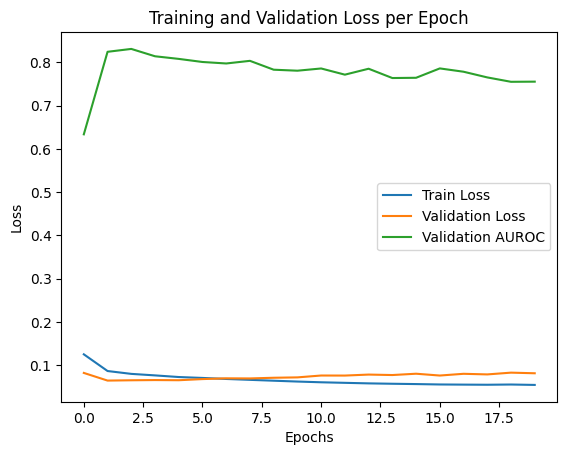

In [11]:
# Plotten van de verliesgrafiek
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.plot(range(len(val_aurocs)), val_aurocs, label='Validation AUROC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [9]:
# Na training:

# 2. Checkpoint laden met weights_only=False
checkpoint = torch.load('checkpoints/best_aurocV2.pth', map_location=device, weights_only=False)

# 3. Laad gewichten
model.load_state_dict(checkpoint['model_state_dict'])


# 4. Eval modus
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        all_preds.extend(probs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Bereken AUROC van het beste model
auroc_best = roc_auc_score(np.array(all_targets), np.array(all_preds), average='macro')
print(f"Best model AUROC: {auroc_best:.4f}")



Best model AUROC: 0.8316



AUROC per class (Best Model):
Class: Atelectasis - Val AUROC: 0.8133
Class: Cardiomegaly - Val AUROC: 0.9205
Class: Consolidation - Val AUROC: 0.7273
Class: Edema - Val AUROC: 0.8791
Class: Effusion - Val AUROC: 0.8610
Class: Emphysema - Val AUROC: 0.9448
Class: Fibrosis - Val AUROC: 0.8175
Class: Hernia - Val AUROC: 0.9348
Class: Infiltration - Val AUROC: 0.7401
Class: Mass - Val AUROC: 0.8613
Class: Nodule - Val AUROC: 0.7821
Class: Pleural_Thickening - Val AUROC: 0.7538
Class: Pneumonia - Val AUROC: 0.7347
Class: Pneumothorax - Val AUROC: 0.8715


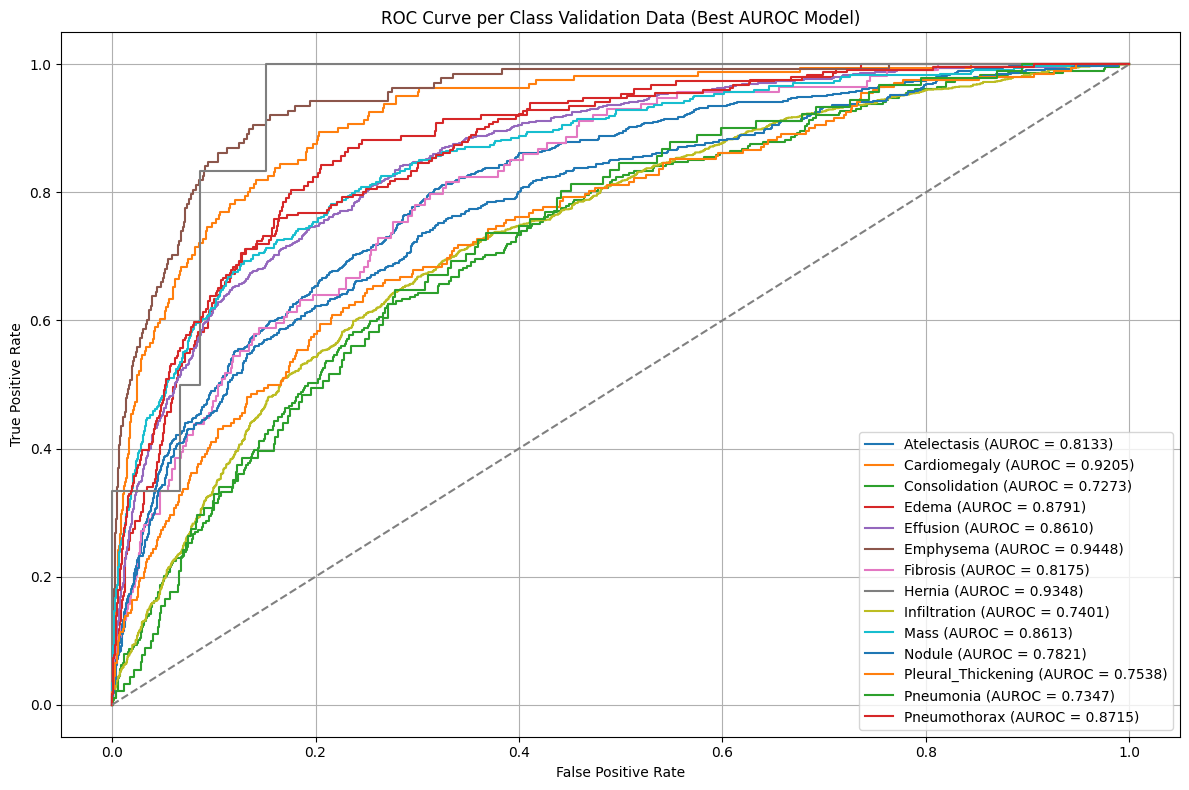

In [13]:
# Definieer de class_names op basis van de kolommen in de encoded CSV
# class_names = label_df_train.columns.tolist()
class_names = df_train.columns.tolist()[1:]

all_preds_np = np.array(all_preds)
all_targets_np = np.array(all_targets)

# AUROC berekenen per klasse voor het beste model
best_val_auroc_per_class = roc_auc_score(all_targets_np, all_preds_np, average=None)

# Print AUROC per klasse voor het beste model
print("\nAUROC per class (Best Model):")
for i, class_name in enumerate(class_names):
    auroc_value = best_val_auroc_per_class[i] if isinstance(best_val_auroc_per_class, np.ndarray) else best_val_auroc_per_class
    print(f"Class: {class_name} - Val AUROC: {auroc_value:.4f}")

# Plot ROC curve per klasse voor het beste model
plt.figure(figsize=(12, 8))
if all_targets_np.ndim > 1 and all_targets_np.shape[1] > 0:
    for i in range(all_targets_np.shape[1]):
        fpr, tpr, _ = roc_curve(all_targets_np[:, i], all_preds_np[:, i])
        auroc_for_class = best_val_auroc_per_class[i] if isinstance(best_val_auroc_per_class, np.ndarray) else np.nan
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {auroc_for_class:.4f})')
else:
    print("Niet genoeg klassen om ROC curves te plotten.")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class Validation Data (Best AUROC Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Testing best model: 100%|██████████| 492/492 [01:15<00:00,  6.55it/s]



Test AUROC (Best Model): 0.8220

Test AUROC per class (Best Model):
Class: Atelectasis - Test AUROC: 0.7781
Class: Cardiomegaly - Test AUROC: 0.9181
Class: Consolidation - Test AUROC: 0.7191
Class: Edema - Test AUROC: 0.8353
Class: Effusion - Test AUROC: 0.8256
Class: Emphysema - Test AUROC: 0.9252
Class: Fibrosis - Test AUROC: 0.8596
Class: Hernia - Test AUROC: 0.9462
Class: Infiltration - Test AUROC: 0.7139
Class: Mass - Test AUROC: 0.8370
Class: Nodule - Test AUROC: 0.7833
Class: Pleural_Thickening - Test AUROC: 0.7779
Class: Pneumonia - Test AUROC: 0.6988
Class: Pneumothorax - Test AUROC: 0.8894


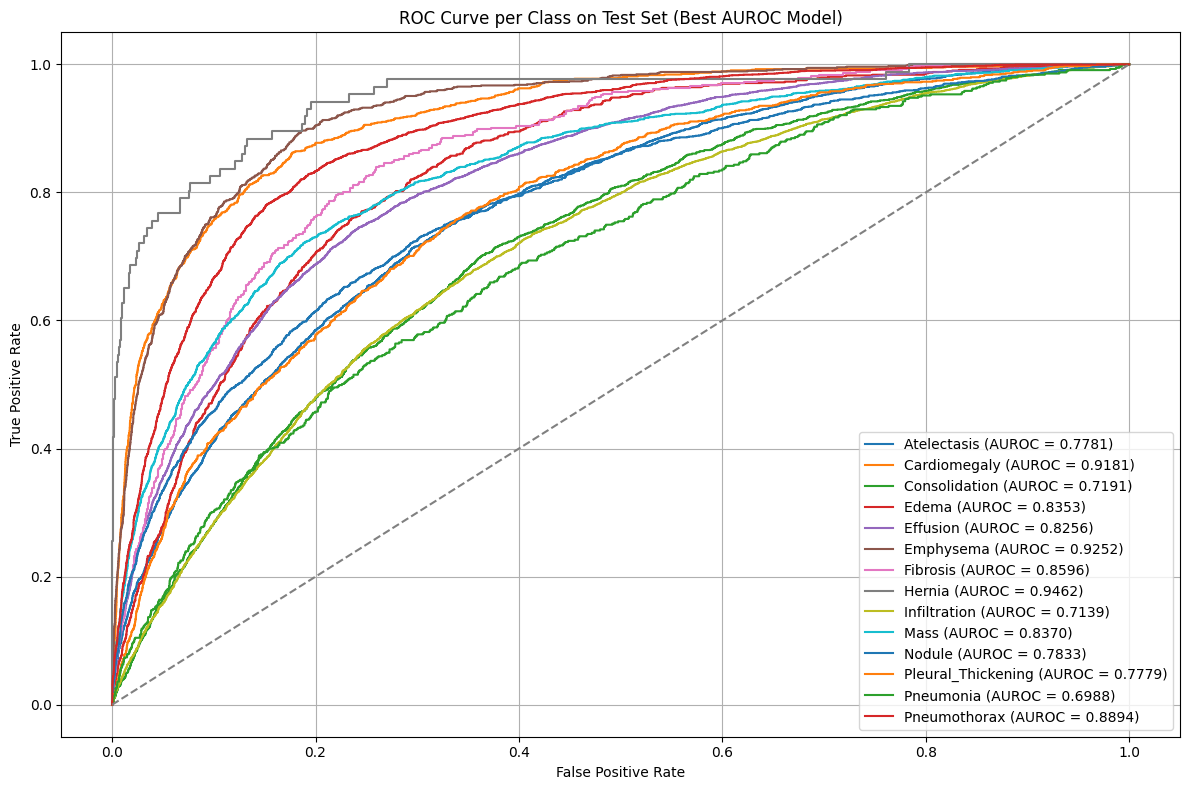

In [14]:
# Zet het model in evaluatiemodus
model.eval()
all_test_preds = []
all_test_targets = []

# Voer de testset door het model zonder gradiënten te berekenen
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing best model"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        # Zorg ervoor dat je hier de sigmoid toepast om waarschijnlijkheden te krijgen
        probs = torch.sigmoid(outputs)
        all_test_preds.extend(probs.cpu().numpy())
        all_test_targets.extend(targets.cpu().numpy())

# Zet om naar numpy arrays
all_test_preds_np = np.array(all_test_preds)
all_test_targets_np = np.array(all_test_targets)

# Bereken de algemene AUROC op de testset
auroc_test = roc_auc_score(all_test_targets_np, all_test_preds_np, average='macro')
print(f"\nTest AUROC (Best Model): {auroc_test:.4f}")

# AUROC berekenen per klasse op de testset
test_auroc_per_class = roc_auc_score(all_test_targets_np, all_test_preds_np, average=None)

# Print AUROC per klasse op de testset
print("\nTest AUROC per class (Best Model):")
for i, class_name in enumerate(class_names):
    auroc_value = test_auroc_per_class[i] if isinstance(test_auroc_per_class, np.ndarray) else test_auroc_per_class
    print(f"Class: {class_name} - Test AUROC: {auroc_value:.4f}")

# Plot ROC curve per klasse op de testset
plt.figure(figsize=(12, 8))
if all_test_targets_np.ndim > 1 and all_test_targets_np.shape[1] > 0:
    for i in range(all_test_targets_np.shape[1]):
        fpr, tpr, _ = roc_curve(all_test_targets_np[:, i], all_test_preds_np[:, i])
        auroc_for_class = test_auroc_per_class[i] if isinstance(test_auroc_per_class, np.ndarray) else np.nan
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {auroc_for_class:.4f})')
else:
    print("Niet genoeg klassen om ROC curves te plotten.")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class on Test Set (Best AUROC Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Youden-index threshold per klasse
num_classes = all_targets.shape[1]
best_thresholds = []

for class_idx in range(num_classes):
    fpr, tpr, thresholds = roc_curve(all_targets[:, class_idx], all_preds[:, class_idx])
    youden_index = tpr - fpr
    best_idx = np.argmax(youden_index)
    best_thresh = thresholds[best_idx]
    best_thresholds.append(best_thresh)
    
    print(f"Class {class_idx} - Best Threshold (Youden): {best_thresh:.3f}, "
          f"TPR: {tpr[best_idx]:.3f}, FPR: {fpr[best_idx]:.3f}, "
          f"Youden Index: {youden_index[best_idx]:.3f}")

Class 0 - Best Threshold (Youden): 0.380, TPR: 0.806, FPR: 0.318, Youden Index: 0.488
Class 1 - Best Threshold (Youden): 0.307, TPR: 0.894, FPR: 0.203, Youden Index: 0.691
Class 2 - Best Threshold (Youden): 0.332, TPR: 0.626, FPR: 0.272, Youden Index: 0.355
Class 3 - Best Threshold (Youden): 0.351, TPR: 0.843, FPR: 0.205, Youden Index: 0.638
Class 4 - Best Threshold (Youden): 0.386, TPR: 0.842, FPR: 0.284, Youden Index: 0.558
Class 5 - Best Threshold (Youden): 0.300, TPR: 0.906, FPR: 0.139, Youden Index: 0.767
Class 6 - Best Threshold (Youden): 0.285, TPR: 0.816, FPR: 0.329, Youden Index: 0.487
Class 7 - Best Threshold (Youden): 0.224, TPR: 1.000, FPR: 0.151, Youden Index: 0.849
Class 8 - Best Threshold (Youden): 0.414, TPR: 0.693, FPR: 0.325, Youden Index: 0.368
Class 9 - Best Threshold (Youden): 0.311, TPR: 0.782, FPR: 0.216, Youden Index: 0.567
Class 10 - Best Threshold (Youden): 0.316, TPR: 0.736, FPR: 0.305, Youden Index: 0.432
Class 11 - Best Threshold (Youden): 0.297, TPR: 0.649

In [18]:
class_names = df_train.columns[1:].tolist()  # eerste kolom is 'Image Index'

In [127]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Binaire predicties maken met de optimale thresholds
binary_preds = np.zeros_like(all_preds)
for i, thresh in enumerate(best_thresholds):
    binary_preds[:, i] = (all_preds[:, i] >= thresh).astype(int)

# Per klasse metrics berekenen
for class_idx in range(num_classes):
    y_true = all_targets[:, class_idx]
    y_pred = binary_preds[:, class_idx]

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)  # sensitiviteit
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Specificiteit = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print(f"Class: {class_names[class_idx]} - Threshold: {best_thresholds[class_idx]:.3f}")
    print(f"  Precision:     {precision:.3f}")
    print(f"  Recall:        {recall:.3f}")
    print(f"  F1 Score:      {f1:.3f}")
    print(f"  Specificity:   {specificity:.3f}")
    print("--------------------------------------------------")

# Gemiddelde scores berekenen en printen
print("Gemiddelde scores over alle klassen:")
print(f"  Precision:     {np.mean(precision):.3f}")
print(f"  Recall:        {np.mean(recall):.3f}")
print(f"  F1 Score:      {np.mean(f1):.3f}")
print(f"  Specificity:   {np.mean(specificity):.3f}")


Class: Atelectasis - Threshold: 0.380
  Precision:     0.422
  Recall:        0.806
  F1 Score:      0.554
  Specificity:   0.682
--------------------------------------------------
Class: Cardiomegaly - Threshold: 0.307
  Precision:     0.173
  Recall:        0.894
  F1 Score:      0.291
  Specificity:   0.797
--------------------------------------------------
Class: Consolidation - Threshold: 0.332
  Precision:     0.170
  Recall:        0.626
  F1 Score:      0.268
  Specificity:   0.728
--------------------------------------------------
Class: Edema - Threshold: 0.351
  Precision:     0.157
  Recall:        0.843
  F1 Score:      0.264
  Specificity:   0.795
--------------------------------------------------
Class: Effusion - Threshold: 0.386
  Precision:     0.480
  Recall:        0.842
  F1 Score:      0.611
  Specificity:   0.716
--------------------------------------------------
Class: Emphysema - Threshold: 0.300
  Precision:     0.209
  Recall:        0.906
  F1 Score:      0.

# GradCam / Attention Mapping
Gradcam on CNN 
Attention Mapping on Swin Transformer

In [16]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [46]:
# Target layer uit CNN-backbone
target_layer = model.cnn_backbone.features[-1]

cam = GradCAM(model=model, target_layers=[target_layer])

# Selecteer één testbeeld en label
input_tensor = inputs[10].unsqueeze(0)  # (1, 3, H, W)
input_tensor = input_tensor.to(device)

# Zet om naar normaal beeld voor visualisatie
input_image = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # normaliseer 0-1

# Target klasse (bijv. top voorspelde index)
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.sigmoid(output)
    top_class = torch.argmax(probs, dim=1).item()

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(top_class)])
cam_image = show_cam_on_image(input_image, grayscale_cam[0], use_rgb=True)

In [98]:
# Pak één sample uit testset
model.eval()
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)
class_names = df_train.columns.tolist()[1:]

# Selecteer een specifiek beeld met meerdere labels
for i in range(inputs.size(0)):
    if targets[i].sum() >= 2:  #  2+ labels 
        selected_input = inputs[i].unsqueeze(0)
        selected_target = targets[i]
        break


In [13]:
# laatste conv layer van CNN
target_layers = [model.cnn_backbone.features[-1]]


In [14]:
class CNNOnlyWrapper(nn.Module):
    def __init__(self, parallel_model):
        super().__init__()
        self.features = parallel_model.cnn_backbone.features
        self.avgpool = parallel_model.cnn_avgpool
        self.classifier = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(parallel_model.cnn_feature_dim, parallel_model.num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [101]:
cnn_only_model = CNNOnlyWrapper(model).to(device)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Init Grad-CAM
cam = GradCAM(model=cnn_only_model, target_layers=target_layers)

# Selecteer één sample met meerdere labels
model.eval()
for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    for i in range(inputs.size(0)):
        if targets[i].sum() >= 2:
            selected_input = inputs[i].unsqueeze(0)
            selected_target = targets[i]
            break
    break


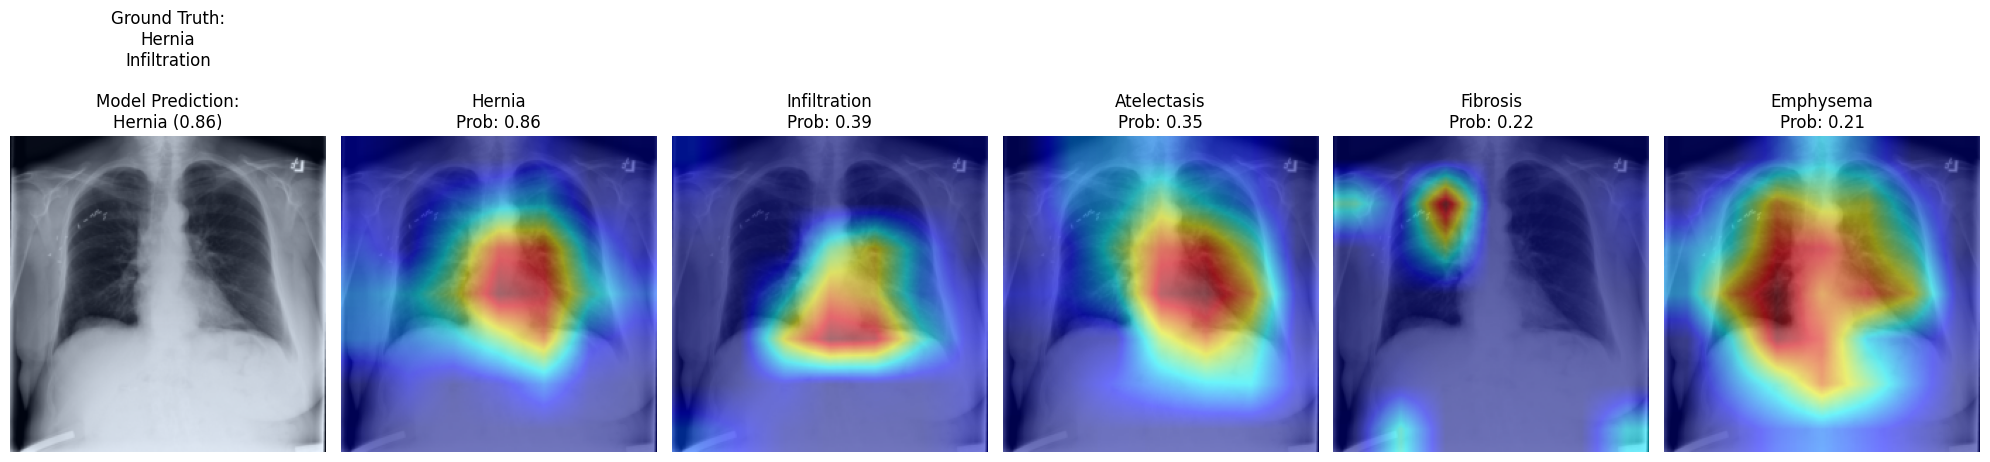

In [111]:
# Gebruik het volledige parallel model voor voorspellingen
probs = torch.sigmoid(model(selected_input))[0].detach().cpu().numpy()
top5_indices = np.argsort(probs)[-5:][::-1]

# Originele input normaliseren voor visualisatie
input_img_np = selected_input.squeeze().detach().cpu().numpy()
if input_img_np.shape[0] == 1:
    input_img_np = np.repeat(input_img_np, 3, axis=0)
input_img_np = np.transpose(input_img_np, (1, 2, 0))
input_img_np = (input_img_np - input_img_np.min()) / (input_img_np.max() - input_img_np.min())

# Plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(20, 5))
axs[0].imshow(input_img_np)
true_label_indices = (selected_target == 1).nonzero(as_tuple=True)[0].cpu().numpy()
true_label_names = [class_names[i] for i in true_label_indices]

top1_class_idx = top5_indices[0]
axs[0].set_title(
    "Ground Truth:\n" + "\n".join(true_label_names) +
    f"\n\nModel Prediction:\n{class_names[top1_class_idx]} ({probs[top1_class_idx]:.2f})"
)

axs[0].axis('off')

for idx, class_idx in enumerate(top5_indices):
    grayscale_cam = cam(input_tensor=selected_input, targets=[ClassifierOutputTarget(class_idx)])[0]
    cam_image = show_cam_on_image(input_img_np, grayscale_cam, use_rgb=True)
    
    axs[idx + 1].imshow(cam_image)
    axs[idx + 1].set_title(f"{class_names[class_idx]}\nProb: {probs[class_idx]:.2f}")
    axs[idx + 1].axis('off')

plt.tight_layout()
plt.show()


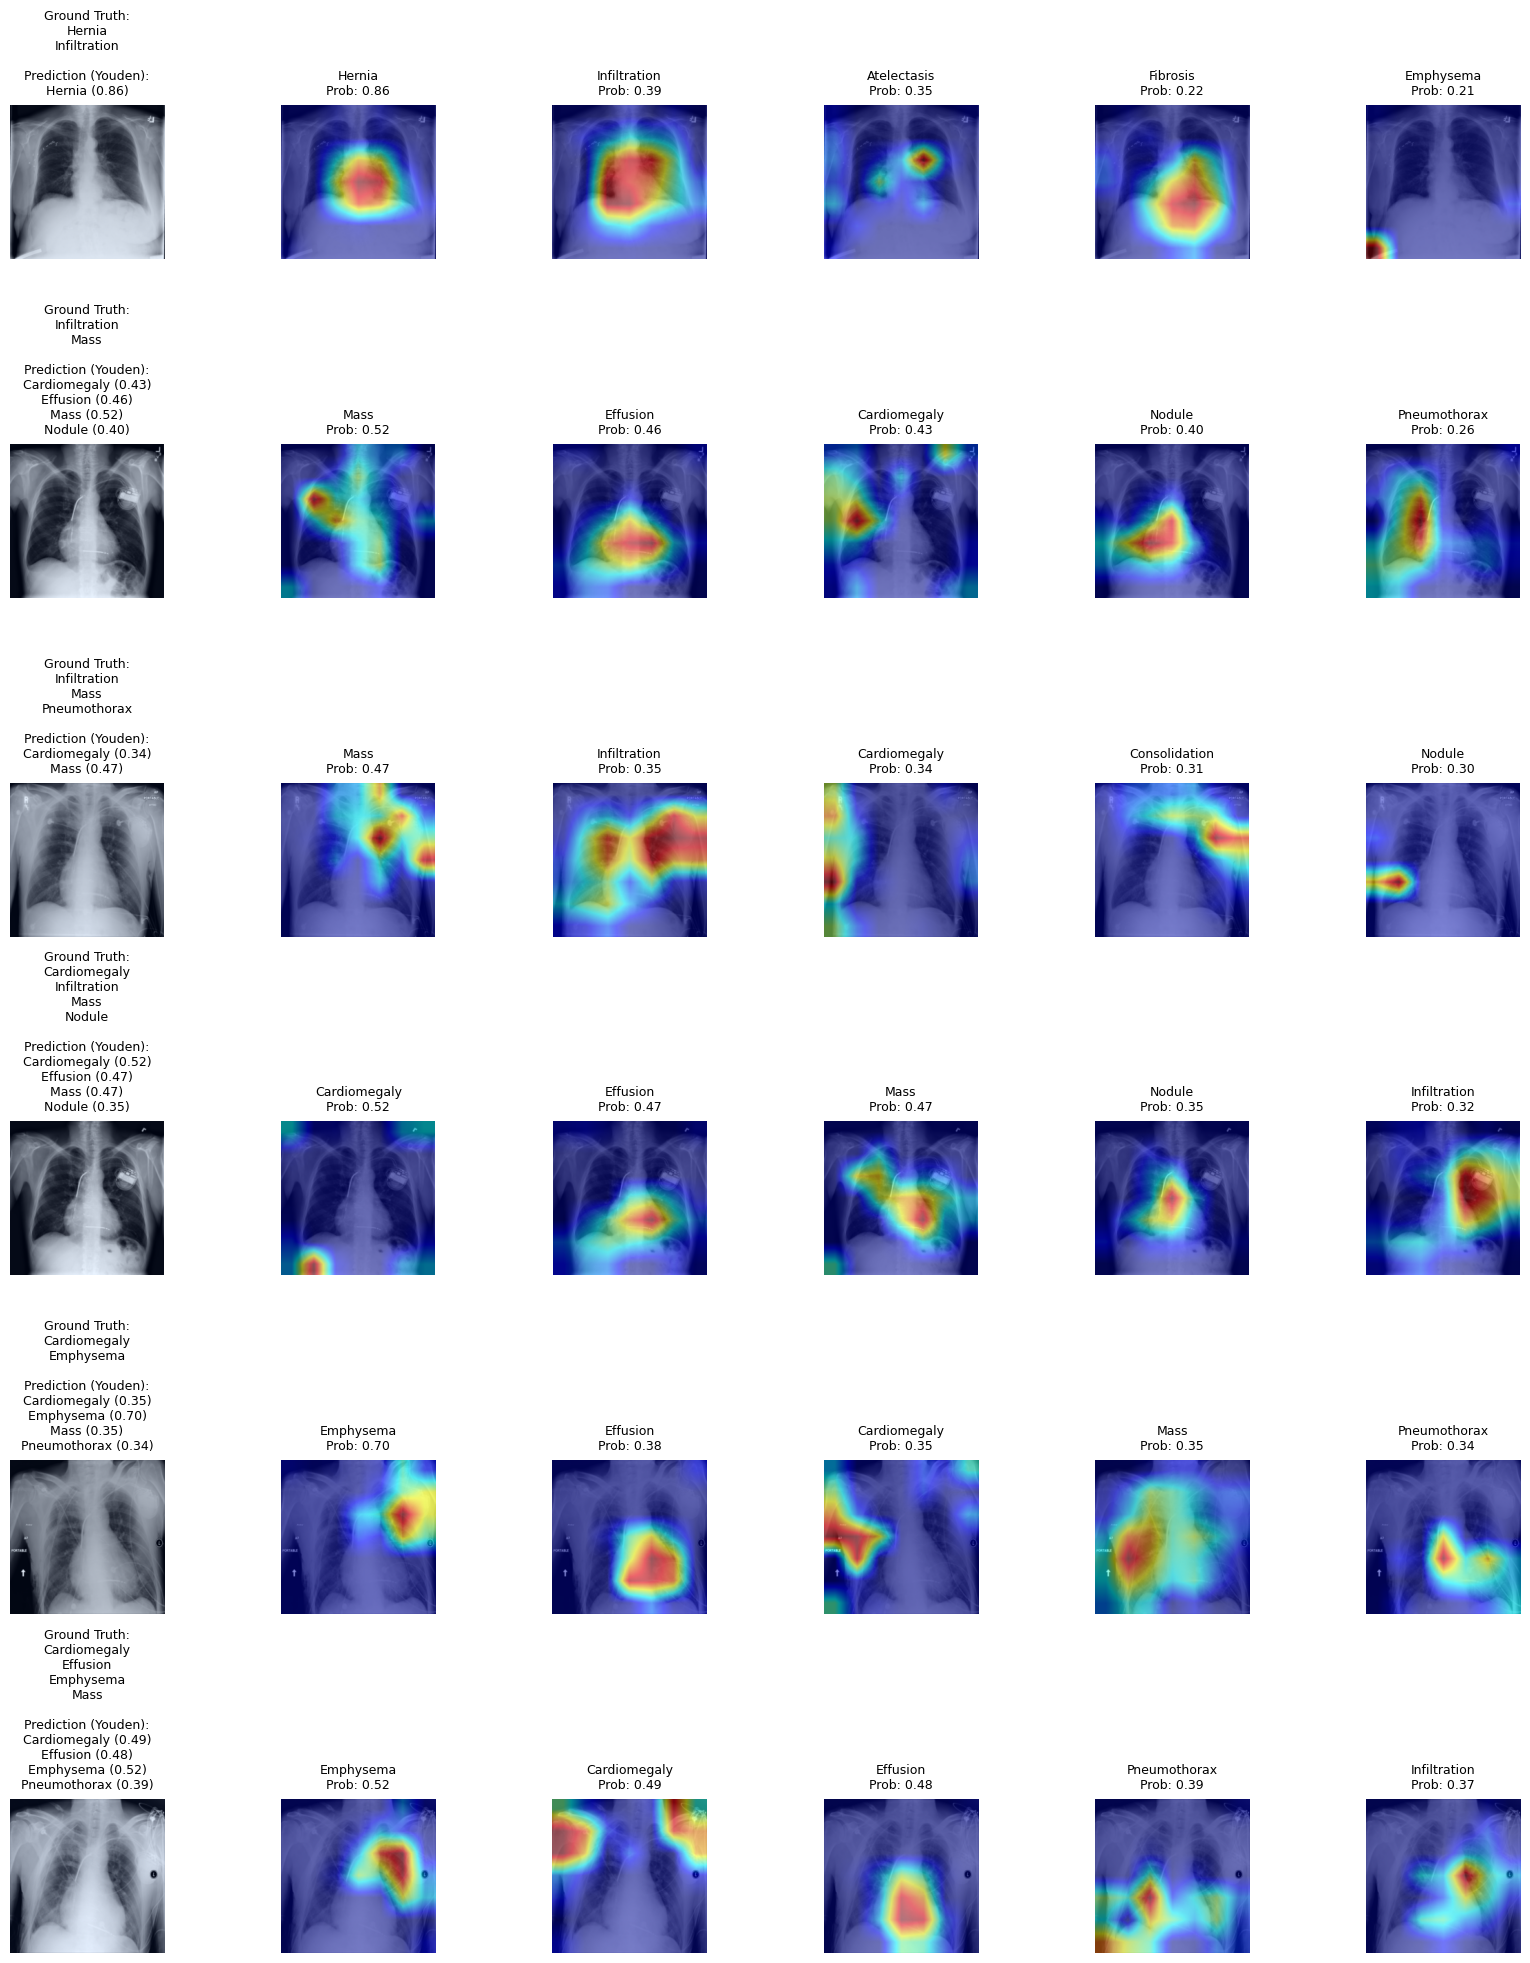

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Setup
num_images = 6
selected_images = []
selected_targets = []

# Verzamel 5 geschikte testbeelden (met >= 2 labels)
model.eval()
for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    for i in range(inputs.size(0)):
        if targets[i].sum() >= 2:
            selected_images.append(inputs[i].unsqueeze(0))
            selected_targets.append(targets[i])
        if len(selected_images) == num_images:
            break
    if len(selected_images) == num_images:
        break

# Grad-CAM setup (alleen CNN-gedeelte)
target_layers = [model.cnn_backbone.features[-1]]
cnn_only_model = CNNOnlyWrapper(model).to(device)
cam = GradCAM(model=cnn_only_model, target_layers=target_layers)

# Stel in: 5 afbeeldingen en bijbehorende best_thresholds (moet vooraf berekend zijn)
assert len(best_thresholds) == len(class_names), "Aantal thresholds komt niet overeen met aantal klassen"

fig, axs = plt.subplots(num_images, 6, figsize=(20, 4 * num_images))

for img_idx in range(num_images):
    selected_input = selected_images[img_idx]
    selected_target = selected_targets[img_idx]

    with torch.no_grad():
        probs = torch.sigmoid(model(selected_input))[0].detach().cpu().numpy()

    top5_indices = np.argsort(probs)[-5:][::-1]

    # Normaliseer input
    input_img_np = selected_input.squeeze().cpu().numpy()
    if input_img_np.shape[0] == 1:
        input_img_np = np.repeat(input_img_np, 3, axis=0)
    input_img_np = np.transpose(input_img_np, (1, 2, 0))
    input_img_np = (input_img_np - input_img_np.min()) / (input_img_np.max() - input_img_np.min())

    # Ground truth en predicties
    true_label_indices = (selected_target == 1).nonzero(as_tuple=True)[0].cpu().numpy()
    true_label_names = [class_names[i] for i in true_label_indices]

    predicted_indices = [i for i, p in enumerate(probs) if p >= best_thresholds[i]]
    predicted_labels = [f"{class_names[i]} ({probs[i]:.2f})" for i in predicted_indices]
    if not predicted_labels:
        predicted_labels = ["<None over threshold>"]

    # Linkerkolom: input image
    axs[img_idx, 0].imshow(input_img_np)
    axs[img_idx, 0].axis('off')
    axs[img_idx, 0].text(
        0.5, 1.05,
        "Ground Truth:\n" + "\n".join(true_label_names) +
        "\n\nPrediction (Youden):\n" + "\n".join(predicted_labels),
        transform=axs[img_idx, 0].transAxes,
        ha='center', va='bottom', fontsize=9
    )

    # CAMs
    for j, class_idx in enumerate(top5_indices):
        grayscale_cam = cam(input_tensor=selected_input, targets=[ClassifierOutputTarget(class_idx)])[0]
        cam_image = show_cam_on_image(input_img_np, grayscale_cam, use_rgb=True)

        axs[img_idx, j + 1].imshow(cam_image)
        axs[img_idx, j + 1].axis('off')
        axs[img_idx, j + 1].text(
            0.5, 1.05,
            f"{class_names[class_idx]}\nProb: {probs[class_idx]:.2f}",
            transform=axs[img_idx, j + 1].transAxes,
            ha='center', va='bottom', fontsize=9
        )

plt.subplots_adjust(hspace=1.2, wspace=0.4)  
plt.show()

# Inference Time

In [11]:
import time

# Zet het model in evaluatiemodus
model.eval()
all_test_preds = []
all_test_targets = []

start_time = time.time()  # Starttijd opnemen

# Voer de testset door het model zonder gradiënten te berekenen
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing best model"):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        all_test_preds.extend(probs.cpu().numpy())
        all_test_targets.extend(targets.cpu().numpy())

end_time = time.time()  # Eindtijd opnemen
total_inference_time = end_time - start_time

num_batches = len(test_loader)
num_samples = len(test_loader.dataset)  # Aantal foto's in de testset

print(f"\nTotale inference time on testset: {total_inference_time:.2f} seconds")
print(f"Average inference time per batch: {total_inference_time / num_batches:.4f} seconds")
print(f"Average inference time per CXR: {total_inference_time / num_samples:.6f} seconds")


Testing best model: 100%|██████████| 492/492 [01:11<00:00,  6.86it/s]


Totale inference time on testset: 71.70 seconds
Average inference time per batch: 0.1457 seconds
Average inference time per CXR: 0.004557 seconds


In [112]:
!conda env export > environment.yml